<a href="https://colab.research.google.com/github/DanishFaraaz/Deep-Learning-Projects/blob/main/26_Pytorch_Google_Deep_Dream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 94.7MB/s]


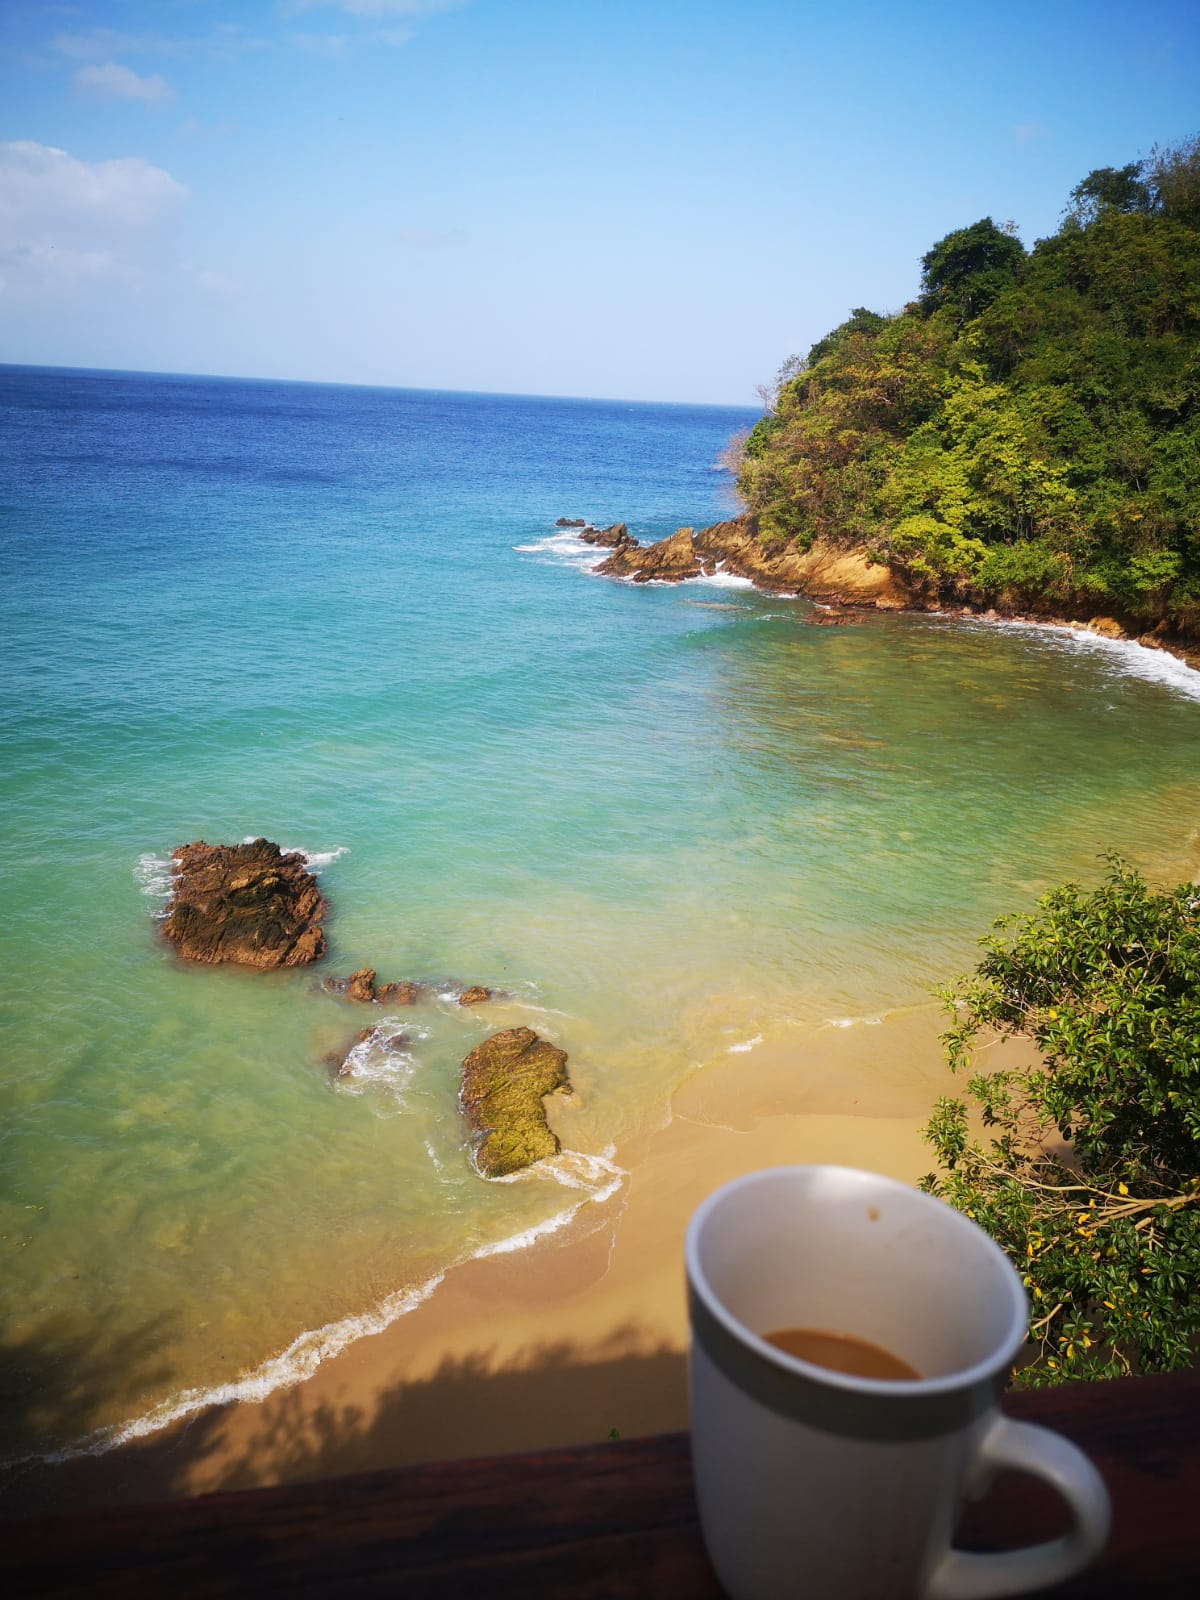

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models

from PIL import Image, ImageFilter, ImageChops
import matplotlib.pyplot as plt

import requests
from io import BytesIO

vgg = models.vgg16(pretrained=True)
vgg = vgg.cuda()
vgg.eval()

url = 'https://github.com/rajeevratan84/ModernComputerVision/raw/main/castara-tobago.jpeg'
response = requests.get(url)
img = Image.open(BytesIO(response.content))

from IPython.display import Image as Img
display(img)

**Get output channels of a layer**

In [12]:
from PIL import Image

#Register a hook on the target channels of a layer (used to get output channels of a layer)
def Hook():
  def __init__(self, module, backward=False):
    if backward == False:
      self.hook = module.register_forward_hook(self.hook_fn)
    else:
      self.hook = module.register_backward_hook(self.hook_fn)
  def hook_fn(self, module, input, output):
    self.input = input
    self.output = output
  def close(self):
    self.hook.remove()

# Gradient calculations from output channels of target layer
def get_gradients(net_in, net, layer):
  net_in = net_in.unsqueeze(0).cuda()
  net.zero_grad()
  hook = Hook(layer)
  net_out = net(net_in)
  loss = hook.output[0].norm()
  loss.backward()
  return net_in.grad.data.squeeze()

denorm = transforms.Compose([ transforms.Normalize(mean = [0., 0., 0.], std = [1/0.229, 1/0.224, 1/0.225]),
                             transforms.Normalize(mean = [-0.485, -0.456, -0.406], std = [1., 1., 1.])])

def dream(image, net, layer, iterations, lr):
  image_tensor = transforms.ToTensor()(image)
  image_tensor = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image_tensor).cuda()
  for i in range(iterations):
    gradients = get_gradients(image_tensor, net, layer)
    image_tensor.data = image_tensor.data + lr * gradients.data

  img_out = image_tensor.detach().cpu()
  img_out = denorm(img_out)
  img_out_np = img_out.numpy().transpose(1,2,0)
  img_out_np = np.clip(img_out_np, 0, 1)
  img_out_pli = Image.fromarray(np.uint8(img_out_np * 255))
  return img_out_pli

**Run the first Google Deep Dream**

In [13]:
orig_size = np.array(img.size)
new_size = np.array(img.size)*0.5
img = img.resize(new_size.astype(int))
layer = list(vgg.features.modules())[27]

img = dream(img, vgg, layer, 20, 1)

img = img.resize(orig_size)
fig = plt.figure(figsize=(10, 10))
plt.imshow(img)

TypeError: ignored